# ASSISTments Data Mining Competition 2017 - Optional Semester Project

## Imports and constants

In [1]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd

DATA_DIR = 'Data/'

## Loading the data

We choose the columns to keep and load all the data into dataframes

In [2]:
student_test_logs = pd.read_pickle(DATA_DIR + 'student_test_logs')
student_train_logs = pd.read_pickle(DATA_DIR + 'student_train_logs')
print(student_train_logs.shape)
student_train_logs.head()

(251488, 37)


,ITEST_id,timeTaken,correct,original,hint,hintCount,hintTotal,scaffold,bottomHint,attemptCount,...,endsWithAutoScaffolding,frTimeTakenOnScaffolding,frTotalSkillOpportunitiesScaffolding,totalFrSkillOpportunitiesByScaffolding,frIsHelpRequestScaffolding,timeGreater5Secprev2wrong,helpAccessUnder2Sec,timeGreater10SecAndNextActionRight,consecutiveErrorsInRow,totalTimeByPercentCorrectForskill
184889,9,15.0,0,1,1,1,1,0,0,1,...,0,0.0,0,0.0,0,0,0,0,0,0.0
184890,9,96.0,1,0,0,0,0,1,0,1,...,0,96.0,0,0.0,1,0,0,1,0,222.0
184891,9,51.0,1,0,0,0,0,1,0,1,...,0,51.0,1,2.0,1,0,0,1,0,243.0
184892,9,27.0,1,0,0,0,0,1,0,1,...,0,27.0,2,1.5,1,0,0,1,0,252.0
184893,9,102.0,0,1,0,0,0,0,0,1,...,0,0.0,0,0.0,0,0,0,0,0,0.0


And the labels

In [3]:
train_labels = pd.read_csv('Data/training_label.csv', index_col='ITEST_id').sort_index()
train_labels.drop_duplicates(subset=None, keep='first', inplace=True)
train_labels.head()

,SchoolId,AveCorrect,MCAS,isSTEM
ITEST_id,,,,
9,2,0.438492,32,1
27,1,0.348837,21,0
33,2,0.686391,52,0
35,2,0.379658,34,0
37,3,0.305785,-999,0


In [4]:
STEM_idx = train_labels[train_labels['isSTEM'] == 1].index.values
nonSTEM_idx = train_labels[train_labels['isSTEM'] == 0].index.values
nonSTEM_idx = nonSTEM_idx[:117]

train_idx = np.concatenate((STEM_idx, nonSTEM_idx))
student_train_logs = student_train_logs[student_train_logs['ITEST_id'].isin(train_idx)]
student_train_logs.shape

(121104, 37)

## Turn the data into tensors

Each tensor have its own size

In [5]:
def actions_to_tensor(actions):
    actions = actions.reset_index(drop=True)
    del actions['ITEST_id']
    tensor = torch.zeros(actions.shape[0], 1, actions.shape[1])
    
    for ai, action in actions.iterrows():
        for i, val in enumerate(action.values):
            tensor[ai][0][i] = val
        
    return tensor

In [6]:
student9 = student_train_logs.loc[student_train_logs['ITEST_id'] == 9]
print(actions_to_tensor(student9))


( 0 ,.,.) = 
  1.5000e+01  0.0000e+00  1.0000e+00  ...   0.0000e+00  0.0000e+00  0.0000e+00

( 1 ,.,.) = 
  9.6000e+01  1.0000e+00  0.0000e+00  ...   1.0000e+00  0.0000e+00  2.2200e+02

( 2 ,.,.) = 
  5.1000e+01  1.0000e+00  0.0000e+00  ...   1.0000e+00  0.0000e+00  2.4300e+02
... 

(501,.,.) = 
  1.0000e+01  0.0000e+00  1.0000e+00  ...   0.0000e+00  0.0000e+00  3.6300e+02

(502,.,.) = 
  3.4000e+01  1.0000e+00  1.0000e+00  ...   0.0000e+00  0.0000e+00  2.8700e+02

(503,.,.) = 
  6.0000e+01  1.0000e+00  1.0000e+00  ...   1.0000e+00  0.0000e+00  4.0250e+02
[torch.FloatTensor of size 504x1x36]



## Creating the network

In [7]:
import torch.nn as nn
from torch.autograd import Variable

In [8]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, batch_size=1, n_layers=1, use_gpu=False):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.use_gpu = use_gpu
        
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=n_layers)
        self.hidden2label = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax()
        self.hidden = self.init_hidden()

    def init_hidden(self):
        if self.use_gpu:
            h0 = Variable(torch.zeros(self.n_layers, self.batch_size, self.hidden_dim).cuda())
            c0 = Variable(torch.zeros(self.n_layers, self.batch_size, self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.n_layers, self.batch_size, self.hidden_dim))
            c0 = Variable(torch.zeros(self.n_layers, self.batch_size, self.hidden_dim))
        return (h0, c0)

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input, self.hidden)
        y = self.hidden2label(lstm_out[-1])
        return self.softmax(y)
        #return y

In [9]:
n_hidden = 128
lstm = LSTMClassifier(student_train_logs.shape[1] - 1, n_hidden, 2)

In [10]:
input = Variable(actions_to_tensor(student9))
lstm.hidden = lstm.init_hidden()

output = lstm(input)
print(output)

Variable containing:
-0.8109 -0.5878
[torch.FloatTensor of size 1x2]



## Training

In [11]:
def isSTEM(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return 1 if category_i == 1 else 0

print(isSTEM(output))

1


In [12]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def training_example(id):
    category = int(train_labels.loc[id].isSTEM)
    
    if category == 1:
        category_tensor = Variable(torch.LongTensor([1]))
    else:
        category_tensor = Variable(torch.LongTensor([0]))
        
    line_tensor = Variable(actions_to_tensor(student_train_logs.loc[student_train_logs['ITEST_id'] == id]))

    return category, category_tensor, line_tensor

In [13]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

def trainLSTM(category_tensor, seq_tensor):
    lstm.hidden = lstm.init_hidden()

    lstm.zero_grad()

    output = lstm(seq_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.data[0]


In [14]:
import time
import math

epochs = 10
print_every = 30
plot_every = 10

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

train_idx = student_train_logs.ITEST_id.unique()

for epoch in range(epochs):
    for iter, student_id in enumerate(train_idx):
        category, category_tensor, sequence_tensor = training_example(student_id)
        output, loss = trainLSTM(category_tensor, sequence_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess = isSTEM(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('Epoch: %d - %d %d%% (%s) %.4f %s / %s %s' % (epoch, iter, iter / len(train_idx) * 100, timeSince(start), loss, student_id, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

Epoch: 0 - 0 0% (0m 1s) 0.5878 9 / 1 ✓
Epoch: 0 - 30 12% (0m 50s) 0.1984 403 / 0 ✓
Epoch: 0 - 60 25% (1m 50s) 0.0374 898 / 0 ✓
Epoch: 0 - 90 38% (2m 41s) 0.1516 1551 / 0 ✓
Epoch: 0 - 120 51% (3m 30s) 0.3196 1960 / 0 ✓
Epoch: 0 - 150 64% (4m 28s) 1.6558 2697 / 0 ✗ (1)
Epoch: 0 - 180 76% (5m 33s) 0.0022 4241 / 1 ✓
Epoch: 0 - 210 89% (6m 25s) 0.0016 6298 / 1 ✓
Epoch: 1 - 0 0% (6m 57s) 0.0021 9 / 1 ✓
Epoch: 1 - 30 12% (7m 54s) 0.0191 403 / 0 ✓
Epoch: 1 - 60 25% (8m 54s) 0.0452 898 / 0 ✓
Epoch: 1 - 90 38% (9m 43s) 0.1412 1551 / 0 ✓
Epoch: 1 - 120 51% (10m 32s) 0.3400 1960 / 0 ✓
Epoch: 1 - 150 64% (11m 27s) 1.1805 2697 / 0 ✗ (1)
Epoch: 1 - 180 76% (12m 32s) 0.0034 4241 / 1 ✓
Epoch: 1 - 210 89% (13m 19s) 0.0017 6298 / 1 ✓
Epoch: 2 - 0 0% (13m 50s) 0.0018 9 / 1 ✓
Epoch: 2 - 30 12% (14m 38s) 0.0167 403 / 0 ✓
Epoch: 2 - 60 25% (15m 35s) 0.1092 898 / 0 ✓
Epoch: 2 - 90 38% (16m 38s) 0.1314 1551 / 0 ✓
Epoch: 2 - 120 51% (17m 31s) 0.2797 1960 / 0 ✓
Epoch: 2 - 150 64% (18m 28s) 2.1408 2697 / 0 ✗ (1)


KeyboardInterrupt: 

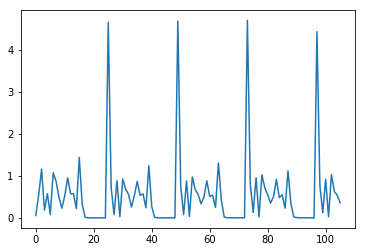

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)